In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test = test.loc[test.ID==1].reset_index(drop=True)
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

tmp = pd.read_csv('../data/df_detect_peptide_test.csv')

tp = set(tmp.PEP.unique())
testp = set(test.PEP.unique())

print(len(tp), len(testp), len(tp.intersection(testp)))

remain_tmp_p = tp.intersection(testp)
remain_idx = [idx for idx, p in zip(test.index, test.PEP.values) if p in remain_tmp_p]

132645 66253 27389


In [4]:
remain_test = test.loc[remain_idx].reset_index(drop=True)

In [5]:
def fifteen2seven(seq):
    if seq=='-':
        return '-'
    else:
        return seq[8:-8]

In [6]:
remain_test['En'] = remain_test.En.apply(fifteen2seven).values
remain_test['Ec'] = remain_test.Ec.apply(fifteen2seven).values
remain_test['E1'] = remain_test.E1.apply(fifteen2seven).values
remain_test['E2'] = remain_test.E2.apply(fifteen2seven).values

In [7]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [8]:
label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
print(label_enc)

{'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}


In [9]:
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(remain_test)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(28060, 39) (28060, 30) (28060, 15) (28060, 15) (28060, 15) (28060, 15) (28060,)


# Train

In [10]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [11]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [12]:
from tensorflow import keras

In [13]:
model_high_re = tf.keras.models.load_model("../compareModel/2021KSBi_multi_lr0005")

In [14]:
model_high_re.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 15)]         0                                            
____________________________________________________________________________________________

In [15]:
pep_output = 'dense_23'
n_output = 'dense_19'
c_output = 'dense_20'
m1_output = 'dense_21'
m2_output = 'dense_22'
intermediate_layer_model = keras.Model(inputs=model_high_re.input,
                                       outputs=[model_high_re.get_layer(pep_output).output,
                                                model_high_re.get_layer(n_output).output,
                                                model_high_re.get_layer(c_output).output,
                                                model_high_re.get_layer(m1_output).output,
                                                model_high_re.get_layer(m2_output).output])

In [16]:
intermediate_layer_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 15)]         0                                            
______________________________________________________________________________________________

In [17]:
pep_out, n_out, c_out, m1_out, m2_out = intermediate_layer_model.predict(
    [pep_test, aa_test, en_test, ec_test, e1_test, e2_test])

In [18]:
en = pd.DataFrame([[ts, 1] for ts in remain_test.En.values], columns=['mers', 'label'])
ec = pd.DataFrame([[ts, 1] for ts in remain_test.Ec.values], columns=['mers', 'label'])
e1 = pd.DataFrame([[ts, 0] for ts in remain_test.E1.values], columns=['mers', 'label'])
e2 = pd.DataFrame([[ts, 0] for ts in remain_test.E2.values], columns=['mers', 'label'])
df_mers = pd.concat([en, ec, e1, e2], axis=0).reset_index(drop=True)
del_idx = [idx for idx, p in zip(df_mers.index, df_mers.mers.values) if p =='-']
df_mers = df_mers.drop(del_idx, axis=0).reset_index(drop=True)

In [19]:
pcnt = {p:0 for p in df_mers.mers.values}
for p in df_mers.mers.values:
    pcnt[p] += 1

In [60]:
sorted(pcnt.items(), key=lambda x: x[1], reverse=True)

[('PTNSQIDKSDFITFG', 24),
 ('SDFITFGKKEETKKK', 22),
 ('KYGPGNPKQSGPGEL', 18),
 ('SPAIISIRQEPTNSQ', 18),
 ('GPGELPDKFIIPGSP', 16),
 ('AIADALGKIPQTVLW', 15),
 ('DFITFGKKEETKKKK', 14),
 ('GEKPYECKECGKAFS', 13),
 ('VTGVEEGRLIFDNLK', 11),
 ('IPQTVLWRYTGTRPS', 11),
 ('VSEIPEKKAMAIADA', 10),
 ('LQHVPDYRQNVYIPG', 10),
 ('IILSDEGKMYGRNEL', 9),
 ('QRIHTGEKPYECKEC', 9),
 ('HIFTVSARDADAQEN', 8),
 ('VINDKSYKENIMRLS', 8),
 ('PAWQNSIRHNLSLND', 8),
 ('SYKENIMRLSSLHKD', 8),
 ('SVHAESGKVYALQPL', 7),
 ('MRLSSLHKDRPVEPL', 7),
 ('NDGPALKKADVGFAM', 7),
 ('PELAEEFKQKFEECQ', 7),
 ('SPDDVEFKSGAGTEL', 7),
 ('TLTNAAGKRDGKAPA', 7),
 ('RLIFDNLKKSIAYTL', 7),
 ('LGAETEEKLFDAPLS', 6),
 ('ILVPIHRKVHWSLVV', 6),
 ('NSNSWTFKYGPGNPK', 6),
 ('EHLAVRFKLQDVADS', 6),
 ('SCVVQTLKEYLESLQ', 6),
 ('IIVEGCQRQGAIVAV', 6),
 ('YEFLWGPRALAETSY', 6),
 ('SRALIKEKLTADPDS', 6),
 ('HPDPEALKGFHPDPE', 6),
 ('VNSNLVCKVSDFGLS', 6),
 ('DEDEDLSKYKLDEDE', 6),
 ('KTPAERLRGPLPPSA', 6),
 ('TGKTRTRKQVSSHIQ', 6),
 ('LSLHNRLRSWVQPPA', 6),
 ('RMALLARKQG

In [61]:
df_mers.loc[df_mers.mers=='PTNSQIDKSDFITFG']

,mers,label
10,PTNSQIDKSDFITFG,1
2492,PTNSQIDKSDFITFG,1
8598,PTNSQIDKSDFITFG,1
9379,PTNSQIDKSDFITFG,1
11731,PTNSQIDKSDFITFG,1
12665,PTNSQIDKSDFITFG,1
12827,PTNSQIDKSDFITFG,1
15505,PTNSQIDKSDFITFG,1
16274,PTNSQIDKSDFITFG,1
16901,PTNSQIDKSDFITFG,1


In [63]:
remain_test.loc[remain_test.En=='PTNSQIDKSDFITFG']

,peptide,En,Ec,E1,E2,protein,PEP,ID
10,K.SDFITFGKK.E,PTNSQIDKSDFITFG,DFITFGKKEETKKKK,SDFITFGKKEETKKK,-,sp|Q9Y5I3|PCDA1_HUMAN,SDFITFGKK,1
2492,K.SDFITFGK.K,PTNSQIDKSDFITFG,SDFITFGKKEETKKK,-,-,sp|Q9Y5H7|PCDA5_HUMAN,SDFITFGK,1
8598,K.SDFITFGKKEETK.K,PTNSQIDKSDFITFG,FGKKEETKKKKKKKK,SDFITFGKKEETKKK,DFITFGKKEETKKKK,sp|Q9Y5H7|PCDA5_HUMAN,SDFITFGKKEETK,1
9379,K.SDFITFGK.K,PTNSQIDKSDFITFG,SDFITFGKKEETKKK,-,-,sp|Q9Y5H6|PCDA8_HUMAN,SDFITFGK,1
11731,K.SDFITFGK.K,PTNSQIDKSDFITFG,SDFITFGKKEETKKK,-,-,sp|Q9H158|PCDC1_HUMAN,SDFITFGK,1
12665,K.SDFITFGKK.E,PTNSQIDKSDFITFG,DFITFGKKEETKKKK,SDFITFGKKEETKKK,-,sp|Q9H158|PCDC1_HUMAN,SDFITFGKK,1
12827,K.SDFITFGKK.E,PTNSQIDKSDFITFG,DFITFGKKEETKKKK,SDFITFGKKEETKKK,-,sp|Q9UN72|PCDA7_HUMAN,SDFITFGKK,1
15505,K.SDFITFGKK.E,PTNSQIDKSDFITFG,DFITFGKKEETKKKK,SDFITFGKKEETKKK,-,sp|Q9Y5H8|PCDA3_HUMAN,SDFITFGKK,1
16274,K.SDFITFGKKEETK.K,PTNSQIDKSDFITFG,FGKKEETKKKKKKKK,SDFITFGKKEETKKK,DFITFGKKEETKKKK,sp|Q9UN73|PCDA6_HUMAN,SDFITFGKKEETK,1
16901,K.SDFITFGKK.E,PTNSQIDKSDFITFG,DFITFGKKEETKKKK,SDFITFGKKEETKKK,-,sp|Q9Y5H9|PCDA2_HUMAN,SDFITFGKK,1


In [65]:
remain_test.loc[remain_test.E1=='PTNSQIDKSDFITFG']

,peptide,En,Ec,E1,E2,protein,PEP,ID
4854,R.QEPTNSQIDKSDFITFGK.K,SPAIISIRQEPTNSQ,SDFITFGKKEETKKK,PTNSQIDKSDFITFG,-,sp|Q9Y5H6|PCDA8_HUMAN,QEPTNSQIDKSDFITFGK,1
8822,R.QEPTNSQIDKSDFITFGK.K,SPAIISIRQEPTNSQ,SDFITFGKKEETKKK,PTNSQIDKSDFITFG,-,sp|Q9H158|PCDC1_HUMAN,QEPTNSQIDKSDFITFGK,1
10214,R.QEPTNSQIDKSDFITFGKK.E,SPAIISIRQEPTNSQ,DFITFGKKEETKKKK,PTNSQIDKSDFITFG,SDFITFGKKEETKKK,sp|Q9Y5I1|PCDAB_HUMAN,QEPTNSQIDKSDFITFGKK,1
15919,R.QEPTNSQIDKSDFITFGKK.E,SPAIISIRQEPTNSQ,DFITFGKKEETKKKK,PTNSQIDKSDFITFG,SDFITFGKKEETKKK,sp|Q9Y5H8|PCDA3_HUMAN,QEPTNSQIDKSDFITFGKK,1
21116,R.QEPTNSQIDKSDFITFGKK.E,SPAIISIRQEPTNSQ,DFITFGKKEETKKKK,PTNSQIDKSDFITFG,SDFITFGKKEETKKK,sp|Q9H158|PCDC1_HUMAN,QEPTNSQIDKSDFITFGKK,1
23213,R.QEPTNSQIDKSDFITFGK.K,SPAIISIRQEPTNSQ,SDFITFGKKEETKKK,PTNSQIDKSDFITFG,-,sp|Q9Y5H9|PCDA2_HUMAN,QEPTNSQIDKSDFITFGK,1
26357,R.QEPTNSQIDKSDFITFGKK.E,SPAIISIRQEPTNSQ,DFITFGKKEETKKKK,PTNSQIDKSDFITFG,SDFITFGKKEETKKK,sp|Q9UN72|PCDA7_HUMAN,QEPTNSQIDKSDFITFGKK,1


In [70]:
# label_enc_rev = {v:k for k, v in label_enc.items()}

# ''.join([label_enc_rev[k] for k in en_test[10]])

# ''.join([label_enc_rev[k] for k in e1_test[4854]])

# n_out[10]

# m1_out[4854]

# TSNE

In [84]:
m1_nonmask_idx = np.array(remain_test.loc[remain_test.E1!='-'].index)
m2_nonmask_idx = np.array(remain_test.loc[remain_test.E2!='-'].index)

In [88]:
m1_out = m1_out[m1_nonmask_idx]
m2_out = m2_out[m2_nonmask_idx]

In [91]:
print(len(n_out), len(c_out), len(m1_out), len(m2_out))

28060 28060 12468 2065


In [96]:
miss = np.concatenate([m1_out, m2_out])
clea = np.concatenate([n_out, c_out])[:len(miss)]
vectors = np.concatenate([clea, miss])

In [99]:
len(miss)

14533

In [97]:
vectors.shape

(29066, 8)

In [101]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [102]:
X_embedded = TSNE(n_components=2).fit_transform(vectors)
for x in range(0, len(X_embedded)):
    if x in range(0, 14533):
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='blue', alpha=0.1)
    else:
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='red', alpha=0.1)

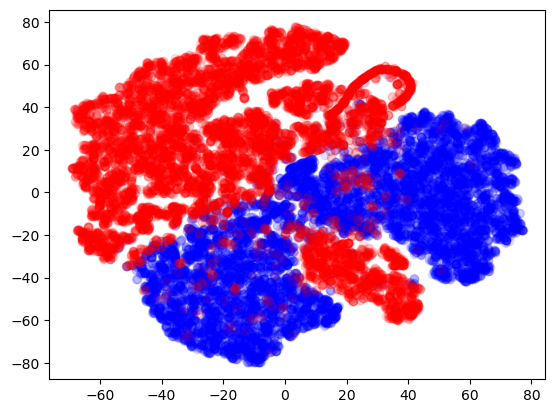

In [103]:
plt.show()

In [105]:
int(len(miss)/2)

7266

In [108]:
miss = np.concatenate([m1_out, m2_out])
clea = np.concatenate([n_out[:int(len(miss)/2)], c_out[:int(len(miss)/2)+1]])
vectors = np.concatenate([clea, miss])

In [109]:
len(miss), len(clea)

(14533, 14533)

In [110]:
vectors.shape

(29066, 8)

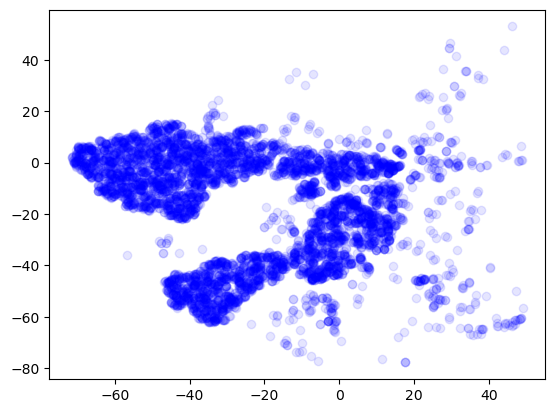

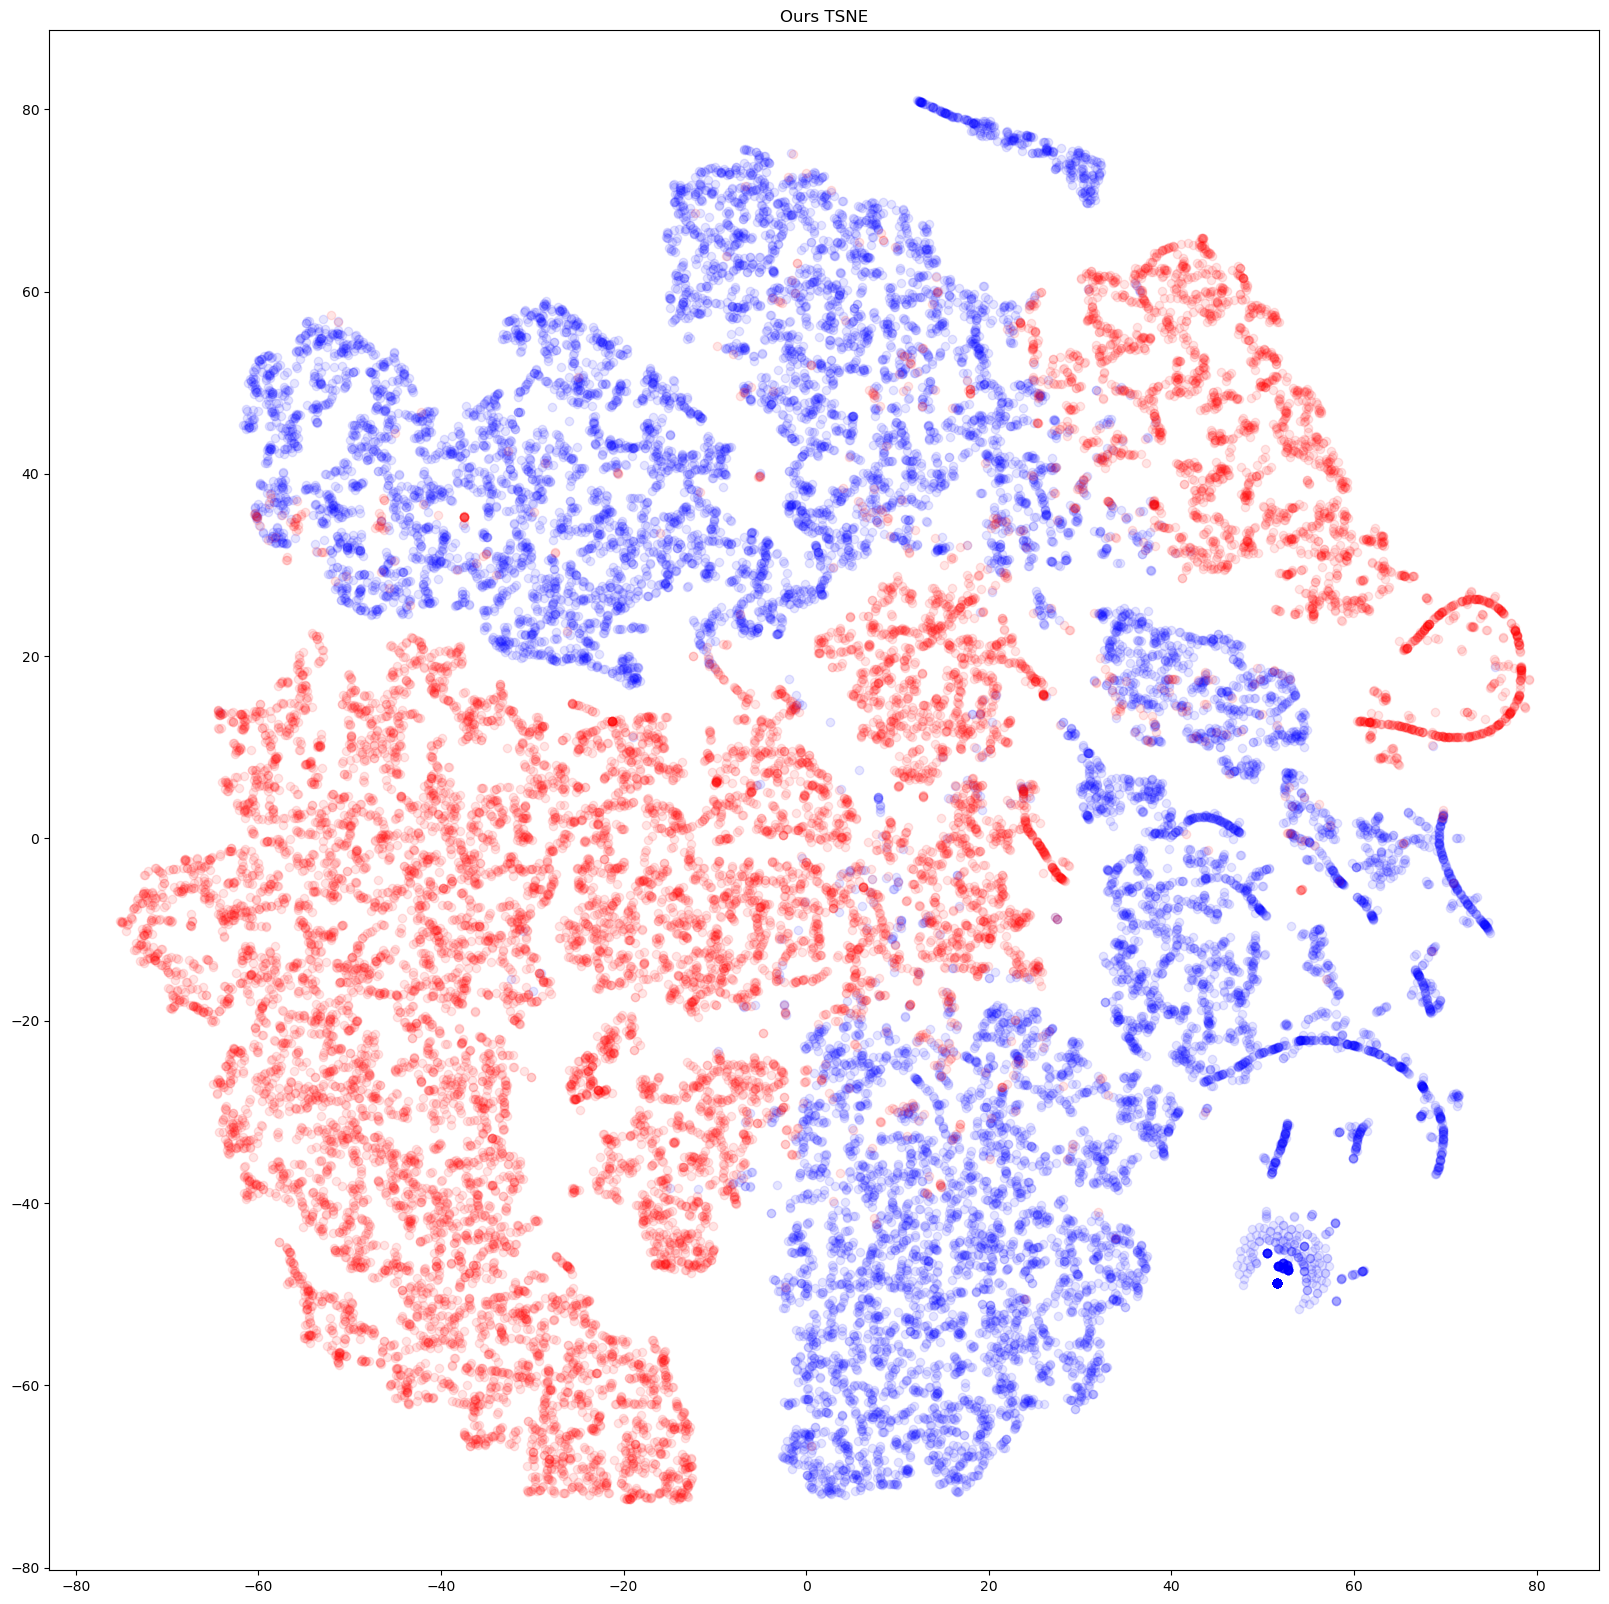

In [112]:
plt.figure(figsize=(20,20))

X_embedded = TSNE(n_components=2).fit_transform(vectors)
for x in range(0, len(X_embedded)):
    if x in range(0, 14533):
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='blue', alpha=0.1)
    else:
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='red', alpha=0.1)

plt.title('Ours TSNE')
plt.show()